In [ ]:
!pip install librosa scikit-learn tensorflow

In [ ]:
import os
import librosa
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.utils import to_categorical

In [ ]:
from google.colab import files
uploaded = files.upload()
!pip install kaggle
import os
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d fabianavinci/guitar-chords-v2
!unzip guitar-chords-v2.zip -d guitar_chords_data

Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/fabianavinci/guitar-chords-v2
License(s): unknown
100% 728M/729M [00:41<00:00, 21.5MB/s]
100% 729M/729M [00:41<00:00, 18.2MB/s]
Archive:  guitar-chords-v2.zip
  inflating: guitar_chords_data/Test/Am/Am_AcousticGuitar_RodrigoMercador_1.wav  
  inflating: guitar_chords_data/Test/Am/Am_AcousticGuitar_RodrigoMercador_2.wav  
  inflating: guitar_chords_data/Test/Am/Am_AcousticGuitar_RodrigoMercador_3.wav  
  inflating: guitar_chords_data/Test/Am/Am_AcousticGuitar_RodrigoMercador_4.wav  
  inflating: guitar_chords_data/Test/Am/Am_AcusticVince_JO_1.wav  
  inflating: guitar_chords_data/Test/Am/Am_AcusticVince_JO_2.wav  
  inflating: guitar_chords_data/Test/Am/Am_AcusticVince_JO_3.wav  
  inflating: guitar_chords_data/Test/Am/Am_AcusticVince_JO_4.wav  
  inflating: guitar_chords_data/Test/Am/Am_Classic2_Carolina_1.wav  
  inflating: guitar_chords_data/Test/Am/Am_Classic2_Carolina_2.wav  
  inflating: guitar_chords_d

In [ ]:
!ls /content/guitar_chords_data
!ls /content/guitar_chords_data/Test
!ls /content/guitar_chords_data/Training
!ls /content/guitar_chords_data/Test/Am
!ls /content/guitar_chords_data/Training/Am

Test  Training
Am  Bb	Bdim  C  Dm  Em  F  G
Am  Bb	Bdim  C  Dm  Em  F  G
Am_AcousticGuitar_RodrigoMercador_1.wav  Am_Classic3_Carolina_3.wav	   Am_Electric1_LInda_1.wav
Am_AcousticGuitar_RodrigoMercador_2.wav  Am_Classic3_Carolina_4.wav	   Am_Electric1_LInda_2.wav
Am_AcousticGuitar_RodrigoMercador_3.wav  Am_classical_AfonsoLemos_-01.wav  Am_Electric1_LInda_3.wav
Am_AcousticGuitar_RodrigoMercador_4.wav  Am_classical_AfonsoLemos_-02.wav  Am_Electric1_LInda_4.wav
Am_AcusticVince_JO_1.wav		 Am_classical_AfonsoLemos_-03.wav  Am_Electric2_LInda_1.wav
Am_AcusticVince_JO_2.wav		 Am_classical_AfonsoLemos_-04.wav  Am_Electric2_LInda_2.wav
Am_AcusticVince_JO_3.wav		 Am_Classic_Jo_1.wav		   Am_Electric2_LInda_3.wav
Am_AcusticVince_JO_4.wav		 Am_Classic_Jo_2.wav		   Am_Electric2_LInda_4.wav
Am_Classic2_Carolina_1.wav		 Am_Classic_Jo_3.wav		   Am_electric_Isabel_1.wav
Am_Classic2_Carolina_2.wav		 Am_Classic_Jo_4.wav		   Am_electric_Isabel_2.wav
Am_Classic2_Carolina_3.wav		 Am_ClassicVince_JO_1.wav	 

## Extract Features




We'll extract MFCCs (Mel-frequency cepstral coefficients), a common feature for audio classification.

In [ ]:
def extract_features(file_path):
    try:
        # Load the audio file
        audio, sample_rate = librosa.load(file_path, res_type='kaiser_fast')

        # Extract MFCCs
        mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
        mfccs_mean = np.mean(mfccs.T, axis=0)  # Mean of the coefficients

        return mfccs_mean
    except Exception as e:
        print(f"Error encountered while parsing file: {file_path}")
        return None

## Convert Audio


Convert Problematic Files

In [ ]:
!apt-get install ffmpeg
import os
import subprocess

def convert_audio_files(input_folder, output_folder, sample_rate=22050):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    for root, _, files in os.walk(input_folder):
        for file in files:
            if file.endswith('.wav'):
                input_file = os.path.join(root, file)
                relative_path = os.path.relpath(root, input_folder)
                output_dir = os.path.join(output_folder, relative_path)
                if not os.path.exists(output_dir):
                    os.makedirs(output_dir)
                output_file = os.path.join(output_dir, file)

                # Convert the file using FFmpeg
                command = f"ffmpeg -i {input_file} -acodec pcm_s16le -ar {sample_rate} {output_file}"
                subprocess.run(command, shell=True)

# Convert files in both Training and Test folders
convert_audio_files('/content/guitar_chords_data/Training', '/content/converted_data/Training')
convert_audio_files('/content/guitar_chords_data/Test', '/content/converted_data/Test')

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
ffmpeg is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.


##Load Data

Add error handling to skip files that still cannot be read after conversion.

In [ ]:
def load_data(data_path):
    features = []
    labels = []
    errors = []

    # Full path to the data folder
    full_data_path = '/content/converted_data/Training'

    for label in os.listdir(full_data_path):
        folder_path = os.path.join(full_data_path, label)
        if os.path.isdir(folder_path):
            # Process each file in the folder
            for file in os.listdir(folder_path):
                file_path = os.path.join(folder_path, file)
                try:
                    # Add code for extracting features from audio files
                    features.append(file_path)  # Dummy feature for now
                    labels.append(label)
                except Exception as e:
                    errors.append(file_path)

    return features, labels, errors


##Usage (Training)

You can split your features and labels into training and validation datasets

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split

# Load the data
features, labels, errors = load_data('/content/converted_data/Training')

# Split the data
X_train, X_val, y_train, y_val = train_test_split(features, labels, test_size=0.2, random_state=42)


# CNN

Ensure all audio files are preprocessed consistently (e.g., converted to spectrograms).

Convert audio files to mel spectrograms or log-mel spectrograms, which CNNs can process as image-like inputs. python Copy code

In [ ]:
import os
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np

def audio_to_spectrogram(file_path, save_path):
    y, sr = librosa.load(file_path, sr=22050)
    spect = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128, fmax=8000)
    log_spect = librosa.power_to_db(spect, ref=np.max)

    plt.figure(figsize=(2.5, 2.5))
    librosa.display.specshow(log_spect, sr=sr, x_axis='time', y_axis='mel', fmax=8000)
    plt.axis('off')
    plt.savefig(save_path, bbox_inches='tight', pad_inches=0)
    plt.close()

# Generate spectrograms for Training dataset
for root, dirs, files in os.walk('/content/converted_data/Training'):
    for file in files:
        if file.endswith('.wav'):
            input_path = os.path.join(root, file)
            output_path = input_path.replace('.wav', '.png').replace('converted_data', 'spectrogram_data')
            os.makedirs(os.path.dirname(output_path), exist_ok=True)
            audio_to_spectrogram(input_path, output_path)

# Generate spectrograms for Test dataset
for root, dirs, files in os.walk('/content/converted_data/Test'):
    for file in files:
        if file.endswith('.wav'):
            input_path = os.path.join(root, file)
            output_path = input_path.replace('.wav', '.png').replace('converted_data', 'spectrogram_data')
            os.makedirs(os.path.dirname(output_path), exist_ok=True)
            audio_to_spectrogram(input_path, output_path)


##Use ImageDataGenerator to load spectrogram images

In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(rescale=1.0/255.0, validation_split=0.2)
train_generator = train_datagen.flow_from_directory(
    '/content/spectrogram_data/Training',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)
val_generator = train_datagen.flow_from_directory(
    '/content/spectrogram_data/Training',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)
test_datagen = ImageDataGenerator(rescale=1.0/255.0)
test_generator = test_datagen.flow_from_directory(
    '/content/spectrogram_data/Test',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)


Found 1151 images belonging to 8 classes.
Found 285 images belonging to 8 classes.
Found 320 images belonging to 8 classes.


##Visualizing Guitar Chord Classes

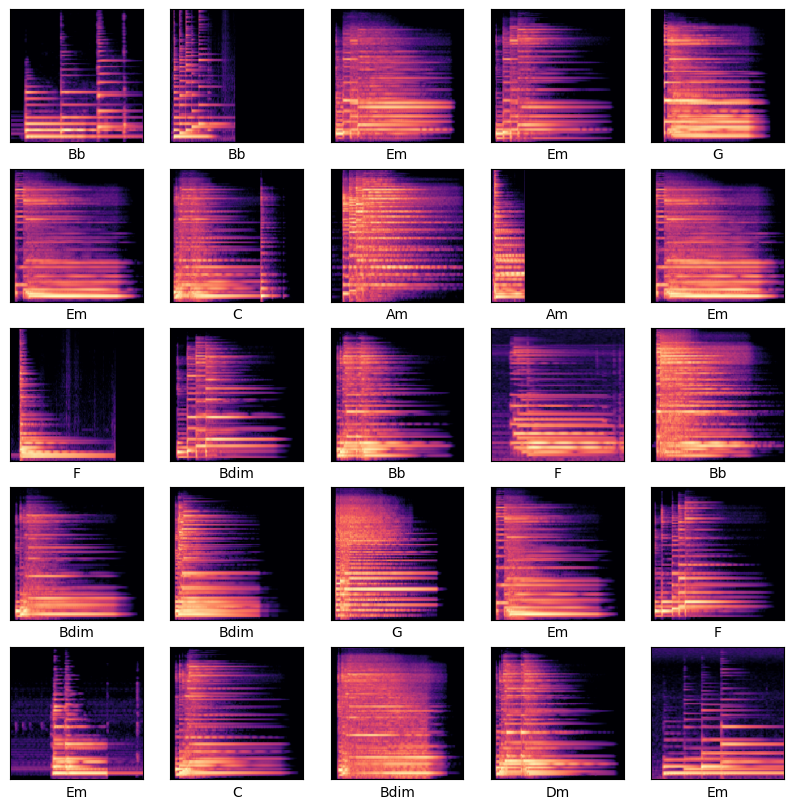

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming train_generator is your training dataset
# and it is created using flow_from_directory with categorical labels.
class_names = list(train_generator.class_indices.keys())  # Retrieve class names from the generator

# Get a batch of training images and labels
train_images, train_labels = next(train_generator)  # Fetch a single batch of data

plt.figure(figsize=(10, 10))
for i in range(25):  # Display 25 images
    plt.subplot(5, 5, i + 1)  # Arrange in a 5x5 grid
    plt.xticks([])  # Remove x-axis ticks
    plt.yticks([])  # Remove y-axis ticks
    plt.grid(False)  # Disable grid
    plt.imshow(train_images[i])  # Display the image
    # Convert one-hot encoded labels back to class names
    label_index = np.argmax(train_labels[i])  # Get the index of the class
    plt.xlabel(class_names[label_index])  # Display the class name
plt.show()


In [ ]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
import os

test_dir = '/content/spectrogram_data/Test/Am'  # Update with actual path
for filename in os.listdir(test_dir):
    if filename.endswith('.png'):
        img = load_img(os.path.join(test_dir, filename), target_size=(224, 224))
        img_array = img_to_array(img)
        print(f"Loaded image shape: {img_array.shape}")
        break


Loaded image shape: (224, 224, 3)


In [ ]:
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Dropout, Dense

# from tensorflow.keras import layers, models

# Define the model
model = models.Sequential()

# First convolutional layer (using an input shape of 224x224x3 for spectrogram images)
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(layers.MaxPooling2D((2, 2)))  # Max pooling layer to downsample

# Second convolutional layer
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))  # Max pooling layer to downsample

# Third convolutional layer
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

# Flatten the output to feed into the fully connected layer
model.add(layers.Flatten())

# Add a fully connected layer (Dense) to classify the guitar chords
model.add(layers.Dense(128, activation='relu'))  # A fully connected layer with 128 units

Dropout(0.5),  # Dropout with 50% probability
layers.Dense(8, activation='softmax')  # Adjust to the number of classes



# Output layer (number of units should match the number of guitar chord classes)
num_classes = len(os.listdir('/content/spectrogram_data/Training'))  # Number of classes based on your training data
model.add(layers.Dense(num_classes, activation='softmax'))  # Softmax for multi-class classification

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Summarize the model
model.summary()



/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 52, 52, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 173056)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │      22,151,296 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 8)                   │           1,032 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 22,208,648 (84.72 MB)

 Trainable params: 22,208,648 (84.72 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(
 '/content/spectrogram_data/Training',  # Correct path to training data
    target_size=(224, 224),
    batch_size=32,
    class_mode='sparse'
)

test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    '/content/spectrogram_data/Test',  # Correct path to test data
    target_size=(224, 224),
    batch_size=32,
   class_mode='sparse'
   )

model.compile(optimizer=Adam(learning_rate=1e-5),  # Lower learning rate
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.fit(
    train_generator,  # Using the generator for training
    epochs=10,
    validation_data=test_generator  # Using the generator for validation
)



Found 1436 images belonging to 8 classes.
Found 320 images belonging to 8 classes.
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/nn.py:635: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(
/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


45/45 ━━━━━━━━━━━━━━━━━━━━ 20s 258ms/step - accuracy: 0.2450 - loss: 2.0254 - val_accuracy: 0.4000 - val_loss: 1.9168
Epoch 2/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 8s 124ms/step - accuracy: 0.6431 - loss: 1.6293 - val_accuracy: 0.7031 - val_loss: 1.5890
Epoch 3/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 10s 125ms/step - accuracy: 0.8787 - loss: 1.1025 - val_accuracy: 0.7875 - val_loss: 1.2257
Epoch 4/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 5s 101ms/step - accuracy: 0.9418 - loss: 0.6498 - val_accuracy: 0.8687 - val_loss: 0.9331
Epoch 5/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 6s 113ms/step - accuracy: 0.9634 - loss: 0.4312 - val_accuracy: 0.8969 - val_loss: 0.7007
Epoch 6/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 6s 125ms/step - accuracy: 0.9681 - loss: 0.2837 - val_accuracy: 0.8969 - val_loss: 0.5821
Epoch 7/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 5s 103ms/step - accuracy: 0.9583 - loss: 0.2453 - val_accuracy: 0.9312 - val_loss: 0.4739
Epoch 8/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 10s 100ms/step - accuracy: 0.9862 - loss: 0.1600 - val_accuracy: 0.9500 - v

In [ ]:
test_loss, test_accuracy = model.evaluate(test_generator)
print(f'Test Loss: {test_loss}, Test Accuracy: {test_accuracy}')


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - accuracy: 0.9487 - loss: 0.3018
Test Loss: 0.30590906739234924, Test Accuracy: 0.9437500238418579


In [ ]:
from google.colab import drive
import os

# Mount Google Drive
drive.mount('/content/drive')

# Create a folder to save the model (if it doesn't exist)
model_folder = '/content/drive/MyDrive/Guitar_Chords_Project/saved_models'
os.makedirs(model_folder, exist_ok=True)  # This will create the folder if it doesn't already exist

# Specify the path to save the model with an appropriate extension (.keras or .h5)
save_path = os.path.join(model_folder, 'my_cnn_model.keras')

# Save the model
model.save(save_path)
print(f"Model saved to {save_path}")



Mounted at /content/drive
Model saved to /content/drive/MyDrive/Guitar_Chords_Project/saved_models/my_cnn_model.keras
